# Integrating the models to the current set up and trying to see if we get a different value for loss with the two models. Result is there is not much difference. Both models show high accurcy but also high loss (likely from class imbalance).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from explainerdashboard import ExplainerDashboard, ClassifierExplainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import captum.attr as c
import time
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import os
from imblearn.over_sampling import SMOTE

In [2]:
def plot_metrics(train, val, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric.
        - val_loss (list): Validation metric.
        - test_loss (list): Test tmetric.
        - epochs (int): The number of epochs.
        - title (string): The title of the plot (imputes the category with type of plot).
    """

    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    plt.xlabel('Epochs')
    plt.ylabel(f"{title}")
    plt.title(f"{title}")
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()

In [3]:
def plot_confusion_matrix(actual_labels, predicted_labels):
    """
    Plot confusion matrix with labels.
    """
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_26312\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [6]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [7]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [8]:
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [9]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Archive.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
print(X_test['label'].value_counts())
X_train = X_train.drop(columns=['attack_cat', 'label'])
X_test = X_test.drop(columns=['attack_cat', 'label'])

label
0    443831
1     64179
Name: count, dtype: int64


In [11]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class NNsmote(nn.Module):
    """
    BinaryFC: A fully connected nn Model. The activation function can be changed.
    """
    def __init__(self, n_features, fc_size, device, save_dir, name):
        super(NNsmote, self).__init__()
        self.name = name
        self.device = device
        self.save_dir = save_dir
        self.fc1 = nn.Linear(n_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)
        # Seleect initial activation.
        self.activation1 = nn.ReLU()
        # Final activation for output.
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)

        # To store metrics.
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.epoch_time = []

    def forward(self, x):
        """
        Forward pass for the Fully Connected model.
        """
        x = self.activation1(self.fc1(x))
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

    def calculate_accuracy_f1(self, predictions, labels):
        """
        Calculate accuracy and F1 score.
        """
        preds = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_loader, criterion, optimizer, epochs, save_factor):
        """
        Train the model.
        """
        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            epoch_loss = 0
            epoch_accuracy = 0
            epoch_f1 = 0
            num_batches = len(train_loader)

            for batch_idx, (train_seq, train_label) in tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
                train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
                batch_size = len(train_seq)
                # Set neighbours to number as batch size.
                smote_neighbors = min(batch_size, 2)
                # When batching the last list is usually inconsistent with the rest.
                if batch_size > 1:
                    try:
                        smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                        train_smote, train_label_smote = smote.fit_resample(train_seq.cpu().numpy(), train_label.cpu().numpy())
                        train_smote = torch.tensor(train_smote, dtype=torch.float32).to(self.device)
                        train_label_smote = torch.tensor(train_label_smote, dtype=torch.float32).to(self.device)
                    # Occurs from inconsistences in list length.
                    except ValueError as e:
                        print('Error running SMOTE.')
                        train_smote, train_label_smote = train_seq, train_label
                else:
                    train_smote, train_label_smote = train_seq, train_label

                optimizer.zero_grad()

                # Forward pass
                outputs = self(train_smote)

                loss = criterion(outputs.squeeze(), train_label_smote)
                loss.backward()
                optimizer.step()

                train_accuracy, train_f1 = self.calculate_accuracy_f1(outputs, train_label_smote)
                epoch_loss += loss.item()
                epoch_accuracy += train_accuracy
                epoch_f1 += train_f1

            # Store overall metrics for the epoch.
            avg_train_loss = epoch_loss / num_batches
            avg_train_accuracy = epoch_accuracy / num_batches
            avg_train_f1 = epoch_f1 / num_batches
            self.train_loss.append(avg_train_loss)
            self.train_accuracy.append(avg_train_accuracy)
            self.train_f1.append(avg_train_f1)
            self.epoch_time.append(time.time() - start_time)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Train F1: {avg_train_f1:.4f}")

            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def test(self, test_loader, criterion):
        """
        Test the model.
        """
        self.eval()
        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        num_batches = len(test_loader)
        with torch.no_grad():
            for test_seq, test_label in tqdm(test_loader, total=num_batches, desc="Testing", unit="batch"):
                test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)
                # Forward pass
                test_outputs = self(test_seq)

                loss = criterion(test_outputs.squeeze(), test_label)
                accuracy, f1 = self.calculate_accuracy_f1(test_outputs, test_label)
                test_loss += loss.item()
                test_accuracy += accuracy
                test_f1 += f1
                preds = (test_outputs > 0.5).float()
                self.test_predicted.extend(preds.cpu().numpy())
        # Store overall test metrics.
        avg_test_loss = test_loss / num_batches
        avg_test_accuracy = test_accuracy / num_batches
        avg_test_f1 = test_f1 / num_batches
        self.test_loss = avg_test_loss
        self.test_accuracy = avg_test_accuracy
        self.test_f1 = avg_test_f1
        print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

    def save_model(self, epoch):
        """
        Save the model state_dict for the given epoch.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
        }, checkpoint_path)

    def load_model(self, epoch):
        """
        Load a state_dict of a model.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fully_connected_size = 64
save_dir = "./saved_models/"
model_name = "NNsmote"
model1 = NNsmote(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir, name=model_name)
criterion = nn.BCEWithLogitsLoss()
# High learning rate for testing purposes.
optimizer = optim.Adam(model1.parameters(), lr=0.05)

model1.run(train_loader, criterion, optimizer, epochs=20, save_factor=100)
model1.test(test_loader, criterion)

Epoch 1/20: 100%|██████████| 15876/15876 [04:19<00:00, 61.24batch/s]


Epoch [1/20], Train Loss: 0.5080, Train Accuracy: 0.9917, Train F1: 0.9917


Epoch 2/20: 100%|██████████| 15876/15876 [04:13<00:00, 62.62batch/s]


Epoch [2/20], Train Loss: 0.5076, Train Accuracy: 0.9928, Train F1: 0.9928


Epoch 3/20: 100%|██████████| 15876/15876 [05:34<00:00, 47.40batch/s]


Epoch [3/20], Train Loss: 0.5078, Train Accuracy: 0.9923, Train F1: 0.9923


Epoch 4/20: 100%|██████████| 15876/15876 [06:51<00:00, 38.59batch/s]


Error running SMOTE.
Epoch [4/20], Train Loss: 0.5077, Train Accuracy: 0.9926, Train F1: 0.9926


Epoch 5/20: 100%|██████████| 15876/15876 [06:55<00:00, 38.25batch/s]


Epoch [5/20], Train Loss: 0.5078, Train Accuracy: 0.9926, Train F1: 0.9926


Epoch 6/20: 100%|██████████| 15876/15876 [06:28<00:00, 40.89batch/s]


Epoch [6/20], Train Loss: 0.5076, Train Accuracy: 0.9928, Train F1: 0.9928


Epoch 7/20: 100%|██████████| 15876/15876 [06:39<00:00, 39.76batch/s]


Epoch [7/20], Train Loss: 0.5076, Train Accuracy: 0.9929, Train F1: 0.9929


Epoch 8/20: 100%|██████████| 15876/15876 [06:54<00:00, 38.29batch/s]


Epoch [8/20], Train Loss: 0.5076, Train Accuracy: 0.9929, Train F1: 0.9929


Epoch 9/20: 100%|██████████| 15876/15876 [06:33<00:00, 40.37batch/s]


Epoch [9/20], Train Loss: 0.5082, Train Accuracy: 0.9913, Train F1: 0.9913


Epoch 10/20: 100%|██████████| 15876/15876 [06:43<00:00, 39.39batch/s]


Epoch [10/20], Train Loss: 0.5082, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 11/20: 100%|██████████| 15876/15876 [06:59<00:00, 37.85batch/s]


Error running SMOTE.
Epoch [11/20], Train Loss: 0.5076, Train Accuracy: 0.9929, Train F1: 0.9929


Epoch 12/20: 100%|██████████| 15876/15876 [06:48<00:00, 38.83batch/s]


Epoch [12/20], Train Loss: 0.5076, Train Accuracy: 0.9929, Train F1: 0.9929


Epoch 13/20: 100%|██████████| 15876/15876 [06:10<00:00, 42.85batch/s]


Epoch [13/20], Train Loss: 0.5076, Train Accuracy: 0.9926, Train F1: 0.9926


Epoch 14/20: 100%|██████████| 15876/15876 [05:01<00:00, 52.66batch/s]


Epoch [14/20], Train Loss: 0.5076, Train Accuracy: 0.9928, Train F1: 0.9928


Epoch 15/20: 100%|██████████| 15876/15876 [05:27<00:00, 48.52batch/s]


Error running SMOTE.
Epoch [15/20], Train Loss: 0.5077, Train Accuracy: 0.9927, Train F1: 0.9927


Epoch 16/20:  79%|███████▊  | 12501/15876 [03:19<00:52, 64.88batch/s]

Error running SMOTE.


Epoch 16/20: 100%|██████████| 15876/15876 [04:15<00:00, 62.05batch/s]


Epoch [16/20], Train Loss: 0.5081, Train Accuracy: 0.9913, Train F1: 0.9913


Epoch 17/20:  11%|█         | 1707/15876 [00:28<03:43, 63.37batch/s]

Error running SMOTE.


Epoch 17/20: 100%|██████████| 15876/15876 [05:09<00:00, 51.26batch/s]


Epoch [17/20], Train Loss: 0.5077, Train Accuracy: 0.9926, Train F1: 0.9926


Epoch 18/20: 100%|██████████| 15876/15876 [06:08<00:00, 43.07batch/s]


Epoch [18/20], Train Loss: 0.5075, Train Accuracy: 0.9930, Train F1: 0.9930


Epoch 19/20: 100%|██████████| 15876/15876 [05:54<00:00, 44.74batch/s]


Epoch [19/20], Train Loss: 0.5075, Train Accuracy: 0.9930, Train F1: 0.9930


Epoch 20/20: 100%|██████████| 15876/15876 [07:06<00:00, 37.20batch/s]


Epoch [20/20], Train Loss: 0.5076, Train Accuracy: 0.9929, Train F1: 0.9929


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 245.94batch/s]

Test Loss: 0.6527, Test Accuracy: 0.9878, Test F1: 0.9882


In [13]:
class NNstandard(nn.Module):
    """
    BinaryFC: A fully connected nn Model. The activation function can be changed.
    """
    def __init__(self, n_features, fc_size, device, save_dir, name):
        super(NNstandard, self).__init__()
        self.name = name
        self.device = device
        self.save_dir = save_dir
        self.fc1 = nn.Linear(n_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)
        self.activation1 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)

        # To store metrics.
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.epoch_time = []

    def forward(self, x):
        """
        Forward pass for the Fully Connected model.
        """
        x = self.activation1(self.fc1(x))
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

    def calculate_accuracy_f1(self, predictions, labels):
        """
        Calculate accuracy and F1 score.
        """
        preds = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_loader, criterion, optimizer, epochs, save_factor, train_labels=None):
        """
        Train the model.
        """
        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            epoch_loss = 0
            epoch_accuracy = 0
            epoch_f1 = 0
            num_batches = len(train_loader)

            for batch_idx, (train_seq, train_label) in tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
                train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
                optimizer.zero_grad()

                # Forward pass
                outputs = self(train_seq)

                loss = criterion(outputs.squeeze(), train_label)
                loss.backward()
                optimizer.step()

                train_accuracy, train_f1 = self.calculate_accuracy_f1(outputs, train_label)
                epoch_loss += loss.item()
                epoch_accuracy += train_accuracy
                epoch_f1 += train_f1

            # Store overall metrics for the epoch.
            avg_train_loss = epoch_loss / num_batches
            avg_train_accuracy = epoch_accuracy / num_batches
            avg_train_f1 = epoch_f1 / num_batches
            self.train_loss.append(avg_train_loss)
            self.train_accuracy.append(avg_train_accuracy)
            self.train_f1.append(avg_train_f1)
            self.epoch_time.append(time.time() - start_time)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Train F1: {avg_train_f1:.4f}")

            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def test(self, test_loader, criterion):
        """
        Test the model.
        """
        self.eval()
        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        num_batches = len(test_loader)
        with torch.no_grad():
            for test_seq, test_label in tqdm(test_loader, total=num_batches, desc="Testing", unit="batch"):
                test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)
                # Forward pass
                test_outputs = self(test_seq)

                loss = criterion(test_outputs.squeeze(), test_label)
                accuracy, f1 = self.calculate_accuracy_f1(test_outputs, test_label)
                test_loss += loss.item()
                test_accuracy += accuracy
                test_f1 += f1
                preds = (test_outputs > 0.5).float()
                self.test_predicted.extend(preds.cpu().numpy())
        # Store overall test metrics.
        avg_test_loss = test_loss / num_batches
        avg_test_accuracy = test_accuracy / num_batches
        avg_test_f1 = test_f1 / num_batches
        self.test_loss = avg_test_loss
        self.test_accuracy = avg_test_accuracy
        self.test_f1 = avg_test_f1
        print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

    def save_model(self, epoch):
        """
        Save the model state_dict for the given epoch.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
        }, checkpoint_path)

    def load_model(self, epoch):
        """
        Load a state_dict of a model.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fully_connected_size = 64
save_dir = "./saved_models/"
model_name = "NNstandard"
model2 = NNstandard(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir, name=model_name)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.05)

model2.run(train_loader, criterion, optimizer, epochs=20, save_factor=100)
model2.test(test_loader, criterion)

Epoch 1/20: 100%|██████████| 15876/15876 [01:54<00:00, 138.54batch/s]


Epoch [1/20], Train Loss: 0.6501, Train Accuracy: 0.9897, Train F1: 0.9896


Epoch 2/20: 100%|██████████| 15876/15876 [01:45<00:00, 150.78batch/s]


Epoch [2/20], Train Loss: 0.6503, Train Accuracy: 0.9899, Train F1: 0.9899


Epoch 3/20: 100%|██████████| 15876/15876 [01:46<00:00, 149.70batch/s]


Epoch [3/20], Train Loss: 0.6508, Train Accuracy: 0.9888, Train F1: 0.9888


Epoch 4/20: 100%|██████████| 15876/15876 [01:31<00:00, 173.73batch/s]


Epoch [4/20], Train Loss: 0.6495, Train Accuracy: 0.9908, Train F1: 0.9907


Epoch 5/20: 100%|██████████| 15876/15876 [01:19<00:00, 200.58batch/s]


Epoch [5/20], Train Loss: 0.6495, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 6/20: 100%|██████████| 15876/15876 [01:20<00:00, 197.94batch/s]


Epoch [6/20], Train Loss: 0.6493, Train Accuracy: 0.9912, Train F1: 0.9911


Epoch 7/20: 100%|██████████| 15876/15876 [01:20<00:00, 197.51batch/s]


Epoch [7/20], Train Loss: 0.6495, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 8/20: 100%|██████████| 15876/15876 [01:19<00:00, 198.73batch/s]


Epoch [8/20], Train Loss: 0.6495, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 9/20: 100%|██████████| 15876/15876 [01:20<00:00, 197.37batch/s]


Epoch [9/20], Train Loss: 0.6503, Train Accuracy: 0.9901, Train F1: 0.9902


Epoch 10/20: 100%|██████████| 15876/15876 [01:20<00:00, 197.13batch/s]


Epoch [10/20], Train Loss: 0.6494, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 11/20: 100%|██████████| 15876/15876 [01:20<00:00, 198.29batch/s]


Epoch [11/20], Train Loss: 0.6495, Train Accuracy: 0.9911, Train F1: 0.9910


Epoch 12/20: 100%|██████████| 15876/15876 [01:27<00:00, 182.44batch/s]


Epoch [12/20], Train Loss: 0.6495, Train Accuracy: 0.9909, Train F1: 0.9909


Epoch 13/20: 100%|██████████| 15876/15876 [01:28<00:00, 180.25batch/s]


Epoch [13/20], Train Loss: 0.6494, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 14/20: 100%|██████████| 15876/15876 [01:22<00:00, 191.63batch/s]


Epoch [14/20], Train Loss: 0.6495, Train Accuracy: 0.9910, Train F1: 0.9910


Epoch 15/20: 100%|██████████| 15876/15876 [01:48<00:00, 146.79batch/s]


Epoch [15/20], Train Loss: 0.6497, Train Accuracy: 0.9903, Train F1: 0.9902


Epoch 16/20: 100%|██████████| 15876/15876 [02:16<00:00, 116.68batch/s]


Epoch [16/20], Train Loss: 0.6494, Train Accuracy: 0.9914, Train F1: 0.9914


Epoch 17/20: 100%|██████████| 15876/15876 [01:59<00:00, 133.12batch/s]


Epoch [17/20], Train Loss: 0.6496, Train Accuracy: 0.9904, Train F1: 0.9903


Epoch 18/20: 100%|██████████| 15876/15876 [02:01<00:00, 131.11batch/s]


Epoch [18/20], Train Loss: 0.6495, Train Accuracy: 0.9906, Train F1: 0.9905


Epoch 19/20: 100%|██████████| 15876/15876 [02:02<00:00, 129.53batch/s]


Epoch [19/20], Train Loss: 0.6494, Train Accuracy: 0.9911, Train F1: 0.9911


Epoch 20/20: 100%|██████████| 15876/15876 [02:04<00:00, 127.57batch/s]


Epoch [20/20], Train Loss: 0.6493, Train Accuracy: 0.9915, Train F1: 0.9915


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 237.60batch/s]

Test Loss: 0.6492, Test Accuracy: 0.9918, Test F1: 0.9918


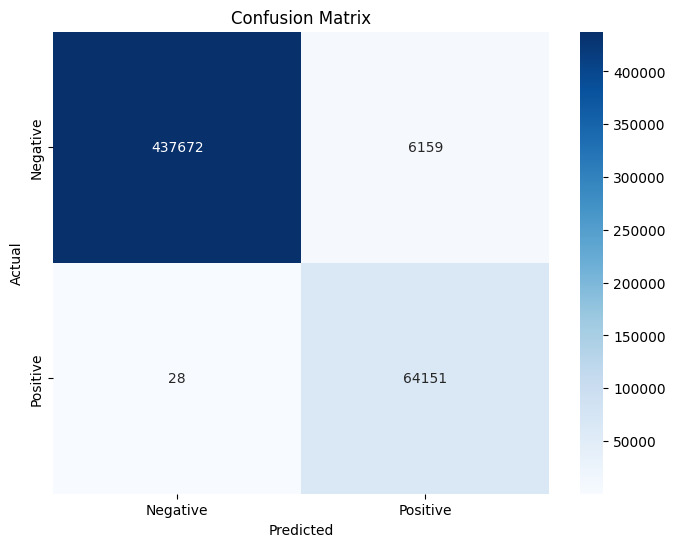

In [16]:
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

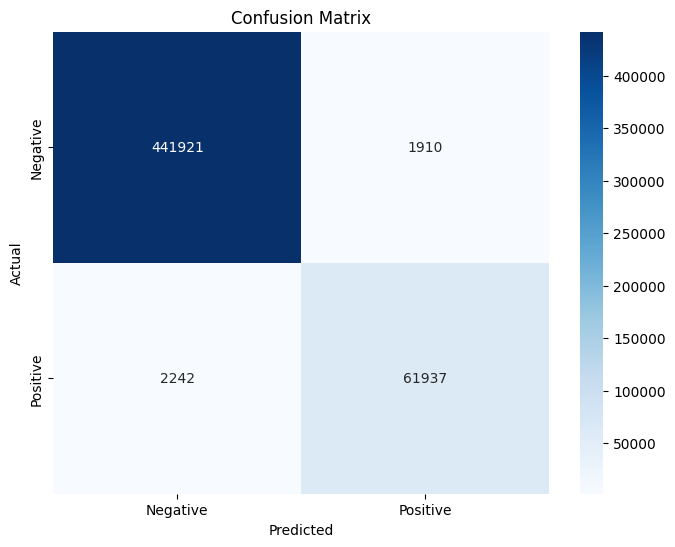

In [17]:
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)